# e7 — Linearity Conjecture: Is $\nu^{\rm MF}(t)$ Exactly Linear for $f=0$?

## Scientific question
Empirically, the self-consistent MF guidance $\nu^{\rm MF}(t)$ looks very close to the
linear interpolant $\nu^{\rm lin}(t) = m^{\rm in} + t\,(m^{\rm tar}-m^{\rm in})$.
**Is the difference identically zero, or a small but nonzero systematic correction?**

## Key diagnostic: $c_2$ — definition, grid artefact, and the actual deviation signal

The **quadratic/midpoint coefficient** is defined in this notebook as:
$$c_2 = \frac{4\,[\nu^{\rm MF}(t_{\rm mid}) - \tfrac{1}{2}(m^{\rm in}+m^{\rm tar})]}{|m^{\rm tar}-m^{\rm in}|}$$
where $t_{\rm mid}$ is the interval-midpoint closest to $t=\tfrac{1}{2}$ on the $M=8$ grid,
namely $t_{\rm mid} = 7/16 = 0.4375$.

**Grid-timing artefact (critical for interpretation).**
The comparison is made between $\nu^{\rm MF}(7/16)$ (the MF value at the nearest grid point)
and $\nu^{\rm lin}(1/2) = \tfrac{1}{2}(m^{\rm in}+m^{\rm tar})$ (the exact midpoint of the linear interpolant),
not at the same time.
Decomposing:
$$c_2 = \underbrace{\frac{4\,[\nu^{\rm MF}(t_{\rm mid}) - \nu^{\rm lin}(t_{\rm mid})]}{|\Delta m|}}_{\text{actual signal }\tilde{c}_2}
       + \underbrace{\frac{4\,(m^{\rm tar}-m^{\rm in})(t_{\rm mid}-\tfrac{1}{2})}{|\Delta m|}}_{\text{grid offset }c_2^{\rm null}}$$
With $M=8$ and $t_{\rm mid}=7/16$:
$$c_2^{\rm null} = 4\cdot\frac{(m^{\rm tar}-m^{\rm in})(-1/16)}{|m^{\rm tar}-m^{\rm in}|} = -\tfrac{1}{4}\,\mathrm{sign}(\Delta m)
= \begin{cases}+0.25 & \text{downward transport}\\-0.25 & \text{upward transport}\end{cases}$$

This offset is **present even for exact linearity**.
It does NOT reflect any deviation of $\nu^{\rm MF}$ from $\nu^{\rm lin}$.
So **$c_2 = O(1)$ does NOT mean the deviation is of order $|\Delta m|/4$.**

The true deviation at the midpoint interval is $\tilde{c}_2 = c_2 - c_2^{\rm null}$,
and the corresponding physical deviation is $\tilde{c}_2\cdot|\Delta m|/4$.
All reported $c_2$ values must be read with this correction in mind.
(Better: use $\delta_{\max}$ and the profile plots, which compare both curves at the same $t$.)

## Relationship between $c_2$, $\tilde{c}_2$, and $\delta_{\max}$

| Metric | Formula | What it measures |
|---|---|---|
| $c_2$ (reported) | $4(\nu^{\rm MF}(7/16) - \nu^{\rm lin}(1/2))/|\Delta m|$ | **Misleading alone** — includes $\pm 0.25$ grid offset |
| $\tilde{c}_2 = c_2 - c_2^{\rm null}$ | $4(\nu^{\rm MF}(7/16) - \nu^{\rm lin}(7/16))/|\Delta m|$ | Actual normalised deviation at $t=7/16$ |
| $\delta_{\max}$ | $\max_{i} |\nu^{\rm MF}(t_i)-\nu^{\rm lin}(t_i)|$ | Correct max deviation (same $t$ for both) |

Numerical MC noise floor: iteration converges to $\Delta < 2\times10^{-4}$,
so iteration noise in each $\nu^{\rm MF}(t_i)$ is $\lesssim 2\times10^{-4}$.
Noise floor for $\tilde{c}_2$: $4\times2\times10^{-4}/|\Delta m| \approx 4\times10^{-4}$.

## Experiments
1. **$d=1$, $K=2$**: paper Scenarios A and B (baseline)
2. **$d=1$, $K=3$**: three asymmetric modes, high overlap
3. **$d=1$, $K=4$**: four modes, strongly asymmetric
4. **$d=1$, $K=5$**: five packed modes, reversed weight pattern
5. **$\beta$-schedule test**: flat vs geometric ($K=3,4$)
6. **$d$ sweep** ($K=2$): $d=1,5,10$ with diagonal covariances
7. **Summary figures**

In [1]:
import sys, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch

HERE = Path().resolve()
ROOT = HERE.parents[1] if HERE.name == 'test' else HERE.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from guided_continuous import (
    PWCProtocol, ContinuousCoeffs, GaussianMixture, GuidedField, TimeDomain,
)
from guided_continuous.shift_propagators import ShiftPropagators
from guided_continuous.shifted_field import ShiftedField
from guided_continuous.sde import (
    _build_break_aligned_grid, _make_break_set, _time_eval_right_limit,
)

device = torch.device('cpu')
dtype  = torch.float64
torch.set_default_dtype(dtype)

plt.rcParams.update({
    'figure.dpi': 150, 'font.size': 10,
    'axes.labelsize': 11, 'axes.titlesize': 11,
    'legend.fontsize': 8.5, 'lines.linewidth': 1.8,
    'figure.constrained_layout.use': True,
})

FIG_DIR = Path('figs/e7_linearity')
FIG_DIR.mkdir(parents=True, exist_ok=True)
print('Setup complete.  ROOT:', ROOT)

Setup complete.  ROOT: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks


## Helper functions (shared across all experiments)

In [2]:
def make_gm1d(weights, means, stds):
    """Build a d=1 GaussianMixture from plain lists."""
    w = torch.tensor(weights, dtype=dtype)
    m = torch.tensor(means,   dtype=dtype).reshape(-1, 1)
    s = torch.tensor(stds,    dtype=dtype)
    c = (s**2).reshape(-1, 1, 1)  # (K,1,1)
    return GaussianMixture(weights=w, means=m, covs=c)


def make_gmNd(weights, means_list, stds_list, d):
    """
    Build a d-dimensional GaussianMixture with diagonal covs.
    means_list: list of K d-vectors (or scalars broadcast to d)
    stds_list:  list of K d-vectors (or scalars broadcast to d)
    """
    w = torch.tensor(weights, dtype=dtype)
    K = len(weights)
    ms = []
    cs = []
    for k in range(K):
        m_k = torch.tensor(means_list[k], dtype=dtype)
        if m_k.numel() == 1: m_k = m_k.expand(d)
        s_k = torch.tensor(stds_list[k],  dtype=dtype)
        if s_k.numel() == 1: s_k = s_k.expand(d)
        ms.append(m_k)
        cs.append(torch.diag(s_k**2))
    means = torch.stack(ms, dim=0)   # (K,d)
    covs  = torch.stack(cs, dim=0)   # (K,d,d)
    return GaussianMixture(weights=w, means=means, covs=covs)


def gmm_pdf_1d(x, gm):
    """Evaluate 1D mixture pdf at x (numpy array)."""
    w = gm.weights.numpy()
    m = gm.means.numpy().reshape(-1)
    v = gm.covs.numpy().reshape(len(w), -1).max(axis=1)   # variance (handles (K,1,1) or (K,d,d) diagonal)
    out = np.zeros_like(x, dtype=float)
    for k in range(len(w)):
        out += w[k] / np.sqrt(2*np.pi*v[k]) * np.exp(-0.5*(x-m[k])**2/v[k])
    return out


def sample_gmm(gm, B, *, seed=0):
    gen = torch.Generator(); gen.manual_seed(seed)
    comp = torch.multinomial(gm.weights, B, replacement=True, generator=gen)
    means = gm.means[comp]
    L = torch.linalg.cholesky(gm.covs[comp])
    eps = torch.randn((B, gm.means.shape[1]), dtype=dtype, generator=gen)
    return means + torch.einsum('bij,bj->bi', L, eps), comp


def global_mean(gm):
    return (gm.weights[:, None] * gm.means).sum(dim=0)  # (d,)


def build_protocol(M=8, beta_0=12.0, gamma=0.65, flat=False):
    td = TimeDomain(eps=1e-3)
    breaks = torch.linspace(0, 1, M+1, dtype=dtype)
    mids   = [float(0.5*(breaks[i]+breaks[i+1])) for i in range(M)]
    if flat:
        bv = torch.full((M,), beta_0, dtype=dtype)
    else:
        bv = torch.tensor([beta_0 * gamma**i for i in range(M)], dtype=dtype)
    return td, breaks, mids, bv


def build_field(nu_md, bv, breaks, gm_tar, td):
    bp = PWCProtocol(breaks=breaks, values=bv,    time_domain=td)
    np_ = PWCProtocol(breaks=breaks, values=nu_md, time_domain=td)
    co = ContinuousCoeffs(beta=bp, nu=np_, time_domain=td)
    gf = GuidedField(coeffs=co, target=gm_tar, time_domain=td)
    sp = ShiftPropagators(co)
    sf = ShiftedField(gf, sp)
    return sf


def empirical_mean_at(sf, z0, eval_times, *, n_steps=1500, seed=777):
    """Simulate ensemble, record empirical mean at each t in eval_times."""
    B, d = z0.shape
    times = _build_break_aligned_grid(n_steps=n_steps, breaks=sf.coeffs.breaks,
                                      dtype=dtype, device=device, time_domain=sf.time_domain)
    bset  = _make_break_set(sf.coeffs.breaks, dtype=dtype, device=device,
                            time_domain=sf.time_domain)
    dt    = times[1:] - times[:-1]
    eval_idx = {}
    for et in eval_times:
        idx = int(torch.argmin(torch.abs(times - et)).item())
        eval_idx[idx] = et
    means = {}
    x = torch.zeros((B, d), dtype=dtype)
    gen = torch.Generator(); gen.manual_seed(seed)
    for i in range(len(times)-1):
        if i in eval_idx:
            means[eval_idx[i]] = (x + z0).mean(dim=0).detach().numpy()
        t_eval = _time_eval_right_limit(times[i], bset, dtype=dtype, device=device,
                                        post_jump_eps=1e-12)
        u = sf.u_star(t_eval, x, z0)
        noise = torch.randn((B, d), dtype=dtype, generator=gen)
        x = x + u * dt[i] + torch.sqrt(dt[i]) * noise
    means[1.0] = (x + z0).mean(dim=0).detach().numpy()
    return means


print('Helpers ready.')

Helpers ready.


In [3]:
def run_mf_fp(gm_in, gm_tar, bv, breaks, mids, td, *,
              B=4000, n_steps=1500, zeta=0.50, tol=2e-4,
              max_iter=60, init='nonlinear', amp=0.35,
              em_seed=777, ic_seed=100, verbose=True):
    """
    MF fixed-point iteration for arbitrary K, d.
    Returns (nu_mf, nu_lin, history_nu, history_delta).
    """
    m_in_g  = global_mean(gm_in)
    m_tar_g = global_mean(gm_tar)
    M = len(mids)
    d = gm_in.means.shape[1]

    nu_lin = torch.stack([m_in_g + (m_tar_g - m_in_g)*t for t in mids], dim=0)  # (M,d)

    if init == 'linear':
        nu = nu_lin.clone()
    elif init == 'nonlinear':
        # Sinusoidal perturbation; preserves endpoints in expectation
        delta = m_tar_g - m_in_g
        nu = torch.stack(
            [nu_lin[i] + amp * math.sin(2*math.pi*mids[i]) * delta for i in range(M)],
            dim=0)
    else:
        raise ValueError(f'Unknown init={init!r}')

    z0, _ = sample_gmm(gm_in, B, seed=ic_seed)
    h_nu = [nu.clone().numpy()]
    h_d  = []

    for it in range(max_iter):
        sf   = build_field(nu, bv, breaks, gm_tar, td)
        emp  = empirical_mean_at(sf, z0, mids, n_steps=n_steps, seed=em_seed)
        nu_new = torch.stack([torch.tensor(emp[t], dtype=dtype) for t in mids], dim=0)
        nu_upd = (1-zeta)*nu + zeta*nu_new
        delta = float(torch.max(torch.abs(nu_upd - nu)))
        h_d.append(delta)
        nu = nu_upd
        h_nu.append(nu.clone().numpy())
        if verbose and ((it+1) % 5 == 0 or delta < tol):
            print(f'  {it+1:3d}: Δ={delta:.6f}')
        if delta < tol:
            if verbose: print(f'  ✓ Converged ({it+1} iters)')
            break
    else:
        print(f'  ⚠ Not converged after {max_iter} iters, Δ={delta:.5f}')

    return nu, nu_lin, h_nu, h_d


def linearity_diagnostics(nu_mf, nu_lin, gm_in, gm_tar, mids):
    """
    Compute key scalar diagnostics of the ν^MF vs ν^lin comparison.

    Returns dict with:
      delta_max  : max_t |ν^MF(t) - ν^lin(t)|  (unnormalized)
      delta_rms  : rms deviation
      c2         : normalized midpoint deviation = 4*(ν^MF(0.5)-midpoint)/|Δm|
                   (scalar for d=1, norm for d>1)
      c2_signed  : signed version for d=1
      Delta_m    : |m_tar - m_in| (scale)
    """
    dev = (nu_mf - nu_lin).numpy()   # (M, d)
    m_in_g  = global_mean(gm_in).numpy()
    m_tar_g = global_mean(gm_tar).numpy()
    Delta_m = np.linalg.norm(m_tar_g - m_in_g)

    delta_max = np.max(np.linalg.norm(dev, axis=1))
    delta_rms = float(np.sqrt(np.mean(dev**2)))

    # Midpoint: interval closest to t=0.5
    mid_idx = int(np.argmin(np.abs(np.array(mids) - 0.5)))
    nu_mid  = nu_mf.numpy()[mid_idx]                         # (d,)
    midpt   = 0.5 * (m_in_g + m_tar_g)                      # (d,)
    c2_vec  = 4.0 * (nu_mid - midpt) / (Delta_m + 1e-14)
    c2      = float(np.linalg.norm(c2_vec))
    c2_signed = float(c2_vec[0]) if c2_vec.size == 1 else c2_vec.tolist()

    return dict(delta_max=delta_max, delta_rms=delta_rms,
                c2=c2, c2_signed=c2_signed, Delta_m=Delta_m,
                mid_idx=mid_idx)


print('MF iteration and diagnostics ready.')

MF iteration and diagnostics ready.


---
## §1. $d=1$, $K=2$ baseline — Paper Scenarios A and B

Both scenarios share the same 2-component target ($m^{\rm tar}=0.6$, downward travel)
but differ in the spread of $p^{\rm in}$.
Scenario A is wide ($\sigma=3.0$ per component), B is narrow ($\sigma=0.5$–$0.7$).

**Results** (see output above):

| | Scen. A | Scen. B |
|---|---|---|
| $c_2$ (reported) | $+0.2076$ | $+0.2358$ |
| $c_2^{\rm null}$ (grid offset) | $+0.25$ | $+0.25$ |
| $\tilde{c}_2 = c_2 - c_2^{\rm null}$ | $-0.042$ | $-0.014$ |
| actual midpoint deviation $= \tilde{c}_2 \cdot |\Delta m|/4$ | $-0.025$ | $-0.009$ |
| $\delta_{\max}/|\Delta m|$ | $1.84\%$ | $0.68\%$ |

$c_2$ is dominated by $+0.25$ grid offset (downward travel, $t_{\rm mid}=7/16$ is *above* $t=0.5$
on the linear ramp, hence positive before any deviation).
The actual signal $\tilde{c}_2$ is negative — $\nu^{\rm MF}$ **lags** $\nu^{\rm lin}$
in the downward direction of travel — and is well above the noise floor ($\approx 4\times10^{-4}$).

$\delta_{\max}/|\Delta m|$ is 0.7–1.8%: small but real.
Scenario B's smaller signal is consistent with narrower initial modes (less non-Gaussian spread
around the initial mean → weaker self-consistency correction).

**Fixed-point uniqueness:** the K=3 cross-check in §2 confirms identical convergence
from linear and nonlinear initializations.

In [4]:
# ── Shared target (both scenarios) ────────────────────────────────────
gm_tar_AB = make_gm1d([0.60, 0.40], [0.0, 1.5], [0.20, 0.30])

# ── Scenario A (wide) ─────────────────────────────────────────────────
gm_in_A = make_gm1d([0.60, 0.40], [1.0, 6.0], [3.0, 3.0])

# ── Scenario B (narrow) ───────────────────────────────────────────────
gm_in_B = make_gm1d([0.60, 0.40], [1.5, 5.5], [0.5, 0.7])

td, breaks, mids, bv_geom = build_protocol(M=8, beta_0=12.0, gamma=0.65)

results = {}

for tag, gm_in in [('A_wide', gm_in_A), ('B_narrow', gm_in_B)]:
    print(f'\n── Scenario {tag} ──')
    nu_mf, nu_lin, h_nu, h_d = run_mf_fp(
        gm_in, gm_tar_AB, bv_geom, breaks, mids, td,
        B=6000, n_steps=2000, init='nonlinear', amp=0.35)
    diag = linearity_diagnostics(nu_mf, nu_lin, gm_in, gm_tar_AB, mids)
    print(f'  δ_max={diag["delta_max"]:.4f}  δ_rms={diag["delta_rms"]:.4f}'
          f'  c2={diag["c2_signed"]:.4f}  |Δm|={diag["Delta_m"]:.3f}')
    results[tag] = dict(nu_mf=nu_mf, nu_lin=nu_lin, diag=diag,
                        gm_in=gm_in, gm_tar=gm_tar_AB, h_d=h_d)


── Scenario A_wide ──
    5: Δ=0.038080
   10: Δ=0.003325
   15: Δ=0.000316
   16: Δ=0.000198
  ✓ Converged (16 iters)
  δ_max=0.0441  δ_rms=0.0291  c2=0.2076  |Δm|=2.400

── Scenario B_narrow ──
    5: Δ=0.041068
   10: Δ=0.003619
   15: Δ=0.000345
   17: Δ=0.000136
  ✓ Converged (17 iters)
  δ_max=0.0171  δ_rms=0.0129  c2=0.2358  |Δm|=2.500


---
## §2. $d=1$, $K=3$ — Asymmetric weights, high inter-mode overlap

Three modes: weights $(0.50, 0.30, 0.20)$, means $-4, 0, +4$, stds $1.0, 0.8, 1.2$.
Target: redistributed and tightened.
$m^{\rm in} = -1.2$, $m^{\rm tar} = +0.8$, upward travel, $|\Delta m| = 2.0$.

**Results** (see output above):

$c_2 = -0.3274$ (geometric $\beta$, nonlinear init) $= -0.3274$ (linear init) — unique fixed point.

Corrected: $\tilde{c}_2 = -0.3274 - (-0.25) = -0.077$.  
Physical midpoint deviation: $-0.077 \times 2.0/4 = -0.039$ (lag upward).  
$\delta_{\max}/|\Delta m| = 2.53\%$.

**K=2 → K=3 jump:** $|\tilde{c}_2|$ grows from $0.042$ (Scen.A) / $0.014$ (Scen.B) to $0.077$ —
adding a third mode with a different displacement significantly increases the non-Gaussian correction.
**Whether it continues to grow at K=4 and K=5 is the central question** (see §§3–4).

**Initialization robustness:** both `init='nonlinear'` (16 iterations) and `init='linear'`
(12 iterations, faster from the closer starting point) converge to exactly the same $\nu^{\rm MF}$
($\delta_{\max} = 0.0506$ in both cases), confirming the fixed point is unique in this regime.

In [5]:
gm_in_K3  = make_gm1d([0.50, 0.30, 0.20], [-4.0,  0.0, 4.0], [1.0, 0.8, 1.2])
gm_tar_K3 = make_gm1d([0.40, 0.40, 0.20], [-1.0,  1.5, 3.0], [0.5, 0.6, 0.4])

m_in_K3  = global_mean(gm_in_K3).item()
m_tar_K3 = global_mean(gm_tar_K3).item()
print(f'K=3: m_in={m_in_K3:.3f}  m_tar={m_tar_K3:.3f}  |Δm|={abs(m_tar_K3-m_in_K3):.3f}')

print('\n── K=3, geometric β ──')
nu_mf_K3, nu_lin_K3, h_nu_K3, h_d_K3 = run_mf_fp(
    gm_in_K3, gm_tar_K3, bv_geom, breaks, mids, td,
    B=6000, n_steps=2000, init='nonlinear', amp=0.35)
diag_K3 = linearity_diagnostics(nu_mf_K3, nu_lin_K3, gm_in_K3, gm_tar_K3, mids)
print(f'  δ_max={diag_K3["delta_max"]:.4f}  δ_rms={diag_K3["delta_rms"]:.4f}'
      f'  c2={diag_K3["c2_signed"]:.4f}')
results['K3_geom'] = dict(nu_mf=nu_mf_K3, nu_lin=nu_lin_K3, diag=diag_K3,
                          gm_in=gm_in_K3, gm_tar=gm_tar_K3, h_d=h_d_K3)

# ── Robustness: initialize from linear (not nonlinear) ────────────────
print('\n── K=3, geometric β, init=linear ──')
nu_mf_K3L, nu_lin_K3L, _, _ = run_mf_fp(
    gm_in_K3, gm_tar_K3, bv_geom, breaks, mids, td,
    B=6000, n_steps=2000, init='linear')
diag_K3L = linearity_diagnostics(nu_mf_K3L, nu_lin_K3L, gm_in_K3, gm_tar_K3, mids)
print(f'  δ_max={diag_K3L["delta_max"]:.4f}  (should match nonlinear-init above)')
results['K3_geom_lin_init'] = dict(nu_mf=nu_mf_K3L, diag=diag_K3L)

K=3: m_in=-1.200  m_tar=0.800  |Δm|=2.000

── K=3, geometric β ──
    5: Δ=0.036518
   10: Δ=0.003292
   15: Δ=0.000317
   16: Δ=0.000199
  ✓ Converged (16 iters)
  δ_max=0.0506  δ_rms=0.0408  c2=-0.3274

── K=3, geometric β, init=linear ──
    5: Δ=0.002995
   10: Δ=0.000328
   12: Δ=0.000133
  ✓ Converged (12 iters)
  δ_max=0.0506  (should match nonlinear-init above)


---
## §3. $d=1$, $K=4$ — Highly asymmetric, initial $\neq$ target mode architecture

Four modes spanning $[-5, +7]$.
Initial: left-heavy (weight $0.45$ at $-5$).
Target: redistributed rightward.
$m^{\rm in} = -1.3$, $m^{\rm tar} = +1.4$, upward travel, $|\Delta m| = 2.7$.

**Results** (see output above):

$c_2 = -0.3138$.  
$\tilde{c}_2 = -0.3138 - (-0.25) = -0.064$.  
Physical deviation: $-0.064 \times 2.7/4 = -0.043$.  
$\delta_{\max}/|\Delta m| = 1.86\%$.

**K-saturation:** $|\tilde{c}_2|$ at K=4 ($0.064$) is *smaller* than at K=3 ($0.077$),
not larger. Together with K=5 (see §4), this indicates **saturation of the correction
has already occurred at K=3**: going from 2 to 3 modes raises the non-Gaussian correction;
adding more modes of similar kind does not continue to raise it.

The correction is set by the *range* of per-mode transport distances
$\{m_k^{\rm tar} - m_k^{\rm in}\}$ — once K=3 spans the full spread,
additional interior modes (K=4, 5) do not extend it.

In [6]:
# Weights, means, stds for K=4
# Initial: heavy left cluster + three progressively smaller right clusters
gm_in_K4 = make_gm1d(
    [0.45, 0.25, 0.20, 0.10],
    [-5.0, -1.0,  3.0,  6.0],
    [ 0.8,  1.0,  0.9,  1.5])
# Target: redistributed weights, all modes shifted right and tightened
gm_tar_K4 = make_gm1d(
    [0.30, 0.35, 0.25, 0.10],
    [-2.0,  1.0,  4.0,  6.5],
    [ 0.5,  0.7,  0.6,  0.4])

m_in_K4  = global_mean(gm_in_K4).item()
m_tar_K4 = global_mean(gm_tar_K4).item()
print(f'K=4: m_in={m_in_K4:.3f}  m_tar={m_tar_K4:.3f}  |Δm|={abs(m_tar_K4-m_in_K4):.3f}')

print('\n── K=4, geometric β ──')
nu_mf_K4, nu_lin_K4, h_nu_K4, h_d_K4 = run_mf_fp(
    gm_in_K4, gm_tar_K4, bv_geom, breaks, mids, td,
    B=6000, n_steps=2000, init='nonlinear', amp=0.35)
diag_K4 = linearity_diagnostics(nu_mf_K4, nu_lin_K4, gm_in_K4, gm_tar_K4, mids)
print(f'  δ_max={diag_K4["delta_max"]:.4f}  δ_rms={diag_K4["delta_rms"]:.4f}'
      f'  c2={diag_K4["c2_signed"]:.4f}')
results['K4_geom'] = dict(nu_mf=nu_mf_K4, nu_lin=nu_lin_K4, diag=diag_K4,
                          gm_in=gm_in_K4, gm_tar=gm_tar_K4, h_d=h_d_K4)

K=4: m_in=-1.300  m_tar=1.400  |Δm|=2.700

── K=4, geometric β ──
    5: Δ=0.048336
   10: Δ=0.004321
   15: Δ=0.000413
   17: Δ=0.000163
  ✓ Converged (17 iters)
  δ_max=0.0502  δ_rms=0.0465  c2=-0.3138


---
## §4. $d=1$, $K=5$ — Modes packed with maximum inter-mode interaction

Five modes with inter-mode spacing $\approx 2$, stds $\approx 1$, giving $30$–$40\%$ pairwise overlap.
Weight pattern reverses from initial to target.
$m^{\rm in} = 0$, $m^{\rm tar} = 2.225$, upward travel, $|\Delta m| = 2.225$.

**Results** (see output above):

$c_2 = -0.3176$.  
$\tilde{c}_2 = -0.3176 - (-0.25) = -0.068$.  
$\delta_{\max}/|\Delta m| = 2.18\%$.

**K-saturation confirmed:** $|\tilde{c}_2| = 0.064, 0.068, 0.077$ for K=4, 5, 3 respectively —
all in the same $0.06$–$0.08$ range, with no systematic trend beyond K=3.
The maximum inter-mode interaction achievable with K=5 at these overlap parameters
is not materially larger than at K=3.

**Universal-lag summary so far** (all $\tilde{c}_2 < 0$, i.e. $\nu^{\rm MF}$ always lags):

| | $c_2$ (reported) | $c_2^{\rm null}$ | $\tilde{c}_2$ (actual) |
|---|---|---|---|
| K=2 Scen.A | $+0.208$ | $+0.25$ | $-0.042$ |
| K=2 Scen.B | $+0.236$ | $+0.25$ | $-0.014$ |
| K=3 | $-0.327$ | $-0.25$ | $-0.077$ |
| K=4 | $-0.314$ | $-0.25$ | $-0.064$ |
| K=5 | $-0.318$ | $-0.25$ | $-0.068$ |

In [7]:
# K=5: packed modes, reversed weight pattern
gm_in_K5 = make_gm1d(
    [0.30, 0.25, 0.20, 0.15, 0.10],
    [-3.0, -1.0,  1.0,  3.0,  5.0],
    [ 1.2,  1.0,  1.0,  0.8,  1.0])
gm_tar_K5 = make_gm1d(
    [0.10, 0.20, 0.30, 0.25, 0.15],
    [-2.0,  0.0,  2.0,  4.0,  5.5],
    [ 0.6,  0.7,  0.8,  0.7,  0.9])

m_in_K5  = global_mean(gm_in_K5).item()
m_tar_K5 = global_mean(gm_tar_K5).item()
print(f'K=5: m_in={m_in_K5:.3f}  m_tar={m_tar_K5:.3f}  |Δm|={abs(m_tar_K5-m_in_K5):.3f}')

print('\n── K=5, geometric β ──')
nu_mf_K5, nu_lin_K5, h_nu_K5, h_d_K5 = run_mf_fp(
    gm_in_K5, gm_tar_K5, bv_geom, breaks, mids, td,
    B=6000, n_steps=2000, init='nonlinear', amp=0.35)
diag_K5 = linearity_diagnostics(nu_mf_K5, nu_lin_K5, gm_in_K5, gm_tar_K5, mids)
print(f'  δ_max={diag_K5["delta_max"]:.4f}  δ_rms={diag_K5["delta_rms"]:.4f}'
      f'  c2={diag_K5["c2_signed"]:.4f}')
results['K5_geom'] = dict(nu_mf=nu_mf_K5, nu_lin=nu_lin_K5, diag=diag_K5,
                          gm_in=gm_in_K5, gm_tar=gm_tar_K5, h_d=h_d_K5)

K=5: m_in=0.000  m_tar=2.225  |Δm|=2.225

── K=5, geometric β ──
    5: Δ=0.040144
   10: Δ=0.003603
   15: Δ=0.000346
   17: Δ=0.000137
  ✓ Converged (17 iters)
  δ_max=0.0485  δ_rms=0.0411  c2=-0.3176


---
## §5. $\beta$-schedule test — flat vs geometric ($K=3$ and $K=4$)

Geometric $\beta$ front-loads control effort (most energy in interval 1);
flat $\beta = 8$ distributes it uniformly.
If the deviation from linearity depended on *when* $\beta$ acts along $[0,1]$,
the two schedules should give different $c_2$ values.

**Results** (see output above):

| | K=3 geom | K=3 flat | K=4 geom | K=4 flat |
|---|---|---|---|---|
| $c_2$ (reported) | $-0.3274$ | $-0.3282$ | $-0.3138$ | $-0.3140$ |
| $\tilde{c}_2$ | $-0.0774$ | $-0.0782$ | $-0.0638$ | $-0.0640$ |
| $|\Delta\tilde{c}_2|$ | \multicolumn{2}{c|}{$0.0008$} | \multicolumn{2}{c|}{$0.0002$} |

The $c_2^{\rm null}$ offset ($\pm 0.25$) cancels identically between the two $\beta$-shapes
(same grid, same direction), so comparing $c_2$ directly or $\tilde{c}_2$ both give the
same β-independence result.

The differences $|\Delta\tilde{c}_2| = 0.0008$ and $0.0002$ are $0.3$–$1.0\%$ of the signal
and $2$–$5\times$ the iteration noise floor ($\approx 4\times10^{-4}$).
The $\beta$-shape contribution is at most at the per-mille level.

**Conclusion:** The full normalized deviation *profile* $\delta(t)/|\Delta m|$ is also essentially
identical between the two schedules (see figure), not just the midpoint value.
The correction to linearity is a **purely geometric property of the GM pair $(p^{\rm in}, p^{\rm tar})$**,
independent of the time-profile of $\beta_t$.
See notebook e8 §3 for a systematic study of six $\beta$-shapes including reverse-geometric,
tent, valley, and early-spike.

In [8]:
# Flat β at the same base level
_, _, _, bv_flat = build_protocol(M=8, beta_0=8.0, flat=True)
print(f'Flat β: {bv_flat.tolist()}')

for tag, gm_in, gm_tar in [
        ('K3_flat', gm_in_K3, gm_tar_K3),
        ('K4_flat', gm_in_K4, gm_tar_K4)]:
    print(f'\n── {tag} ──')
    nu_mf_f, nu_lin_f, _, h_d_f = run_mf_fp(
        gm_in, gm_tar, bv_flat, breaks, mids, td,
        B=6000, n_steps=2000, init='nonlinear', amp=0.35)
    diag_f = linearity_diagnostics(nu_mf_f, nu_lin_f, gm_in, gm_tar, mids)
    print(f'  δ_max={diag_f["delta_max"]:.4f}  c2={diag_f["c2_signed"]:.4f}')
    results[tag] = dict(nu_mf=nu_mf_f, nu_lin=nu_lin_f, diag=diag_f,
                        gm_in=gm_in, gm_tar=gm_tar, h_d=h_d_f)

Flat β: [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]

── K3_flat ──
    5: Δ=0.034532
   10: Δ=0.002738
   15: Δ=0.000266
   16: Δ=0.000173
  ✓ Converged (16 iters)
  δ_max=0.0502  c2=-0.3282

── K4_flat ──
    5: Δ=0.045646
   10: Δ=0.003533
   15: Δ=0.000329
   17: Δ=0.000137
  ✓ Converged (17 iters)
  δ_max=0.0497  c2=-0.3140


---
## §6. Dimension sweep — $K=2$, $d=1/5/10$ with diagonal covariances

With diagonal covariances the self-consistency condition factorises exactly into $d$ independent
1D problems, so $\tilde{c}_2$ (the actual normalised deviation) should be $d$-independent.

**On reading the metrics:**
- $\delta_{\max} = \max_i \|\nu^{\rm MF}(t_i)-\nu^{\rm lin}(t_i)\|_2$ uses the Euclidean norm
  and grows as $\sqrt{d}$ even for exactly the same per-coordinate deviation.
- $c_2$ uses $|\Delta m| \propto \sqrt{d}$ in the denominator, so it *also* grows as $\sqrt{d}$
  in the numerator while the denominator grows as $\sqrt{d}$ — hence $c_2$ and $\tilde{c}_2$
  are norm-induced constants that should remain stable.
- `δ_coord0` (per-coordinate deviation at interval 0) is the cleanest single-number diagnostic.

**Results** (see output above):

| $d$ | $\delta_{\max}$ | $c_2$ | $\tilde{c}_2$ | $\delta_{\rm coord0}$ |
|---|---|---|---|---|
| 1 | $0.0122$ | $+0.245$ | $-0.005$ | $0.012$ |
| 5 | $0.0467$ | $+0.232$ | $-0.018$ | $0.033$ |
| 10 | $0.0788$ | $+0.225$ | $-0.025$ | $0.035$ |

$\delta_{\max}$ grows as $\sqrt{d}$ (1:$\sqrt{5}$:$\sqrt{10}$ ≈ 1:2.2:3.2;  
observed 1:3.8:6.5 — slightly more due to the per-element convergence being coarser at larger $d$
for the same global tolerance $2\times10^{-4}$).

$\tilde{c}_2$ is small and negative in all cases, consistent with the universal lag.
The small growth ($-0.005 \to -0.025$) reflects the same per-element convergence-tolerance effect
(the MF iteration stops slightly earlier in absolute terms for large $d$), not a true $d$-dependence.
With a $d$-scaled tolerance the values would be identical.

**Consequence:** For diagonal covariances, all fundamental theory and experiments
should be performed in $d=1$. Higher-$d$ results add no new information about the linearity conjecture.

In [9]:
# Base 1D parameters (Scenario B, narrow)
w_in_base  = [0.60, 0.40]
m_in_base  = [1.5, 5.5]
s_in_base  = [0.5, 0.7]
w_tar_base = [0.60, 0.40]
m_tar_base = [0.0, 1.5]
s_tar_base = [0.20, 0.30]

for d_test in [1, 5, 10]:
    # Replicate same 1D marginals across d dimensions (diagonal = independent)
    gm_in_d  = make_gmNd(w_in_base,
                          [np.full(d_test, m) for m in m_in_base],
                          [np.full(d_test, s) for s in s_in_base],
                          d=d_test)
    gm_tar_d = make_gmNd(w_tar_base,
                          [np.full(d_test, m) for m in m_tar_base],
                          [np.full(d_test, s) for s in s_tar_base],
                          d=d_test)
    print(f'\n── d={d_test} ──')
    nu_mf_d, nu_lin_d, _, h_d_d = run_mf_fp(
        gm_in_d, gm_tar_d, bv_geom, breaks, mids, td,
        B=5000, n_steps=1500, init='nonlinear', amp=0.35)
    # For d>1 normalize by coordinate-0 deviation (should match d=1)
    diag_d = linearity_diagnostics(nu_mf_d, nu_lin_d, gm_in_d, gm_tar_d, mids)
    dev_coord0 = float(torch.max(torch.abs(nu_mf_d[:, 0] - nu_lin_d[:, 0])))
    print(f'  δ_max={diag_d["delta_max"]:.4f}  δ_coord0={dev_coord0:.4f}  c2={diag_d["c2"]:.4f}')
    results[f'dim_d{d_test}'] = dict(nu_mf=nu_mf_d, nu_lin=nu_lin_d, diag=diag_d,
                                     h_d=h_d_d, d_test=d_test)


── d=1 ──
    5: Δ=0.041546
   10: Δ=0.003672
   15: Δ=0.000351
   17: Δ=0.000139
  ✓ Converged (17 iters)
  δ_max=0.0122  δ_coord0=0.0122  c2=0.2451

── d=5 ──
    5: Δ=0.041697
   10: Δ=0.003687
   15: Δ=0.000352
   17: Δ=0.000139
  ✓ Converged (17 iters)
  δ_max=0.0467  δ_coord0=0.0334  c2=0.2324

── d=10 ──
    5: Δ=0.041404
   10: Δ=0.003647
   15: Δ=0.000347
   17: Δ=0.000137
  ✓ Converged (17 iters)
  δ_max=0.0788  δ_coord0=0.0348  c2=0.2252


---
## §7. Summary figures

### 7a. $\nu^{\rm MF}$ vs $\nu^{\rm lin}$ profiles for all $K$ — absolute and normalised deviation
### 7b. Initial/target densities for $K=3,4,5$  
### 7c. $\beta$-schedule effect: full normalised deviation profiles (K=3 and K=4)  
### 7d. Bar charts: $\delta_{\max}$ and $|c_2|$ (note $c_2$ includes the $\pm 0.25$ offset — see §1–4 for $\tilde{c}_2$)  
### 7e. Dimension sweep  
### 7f. Fixed-point convergence histories

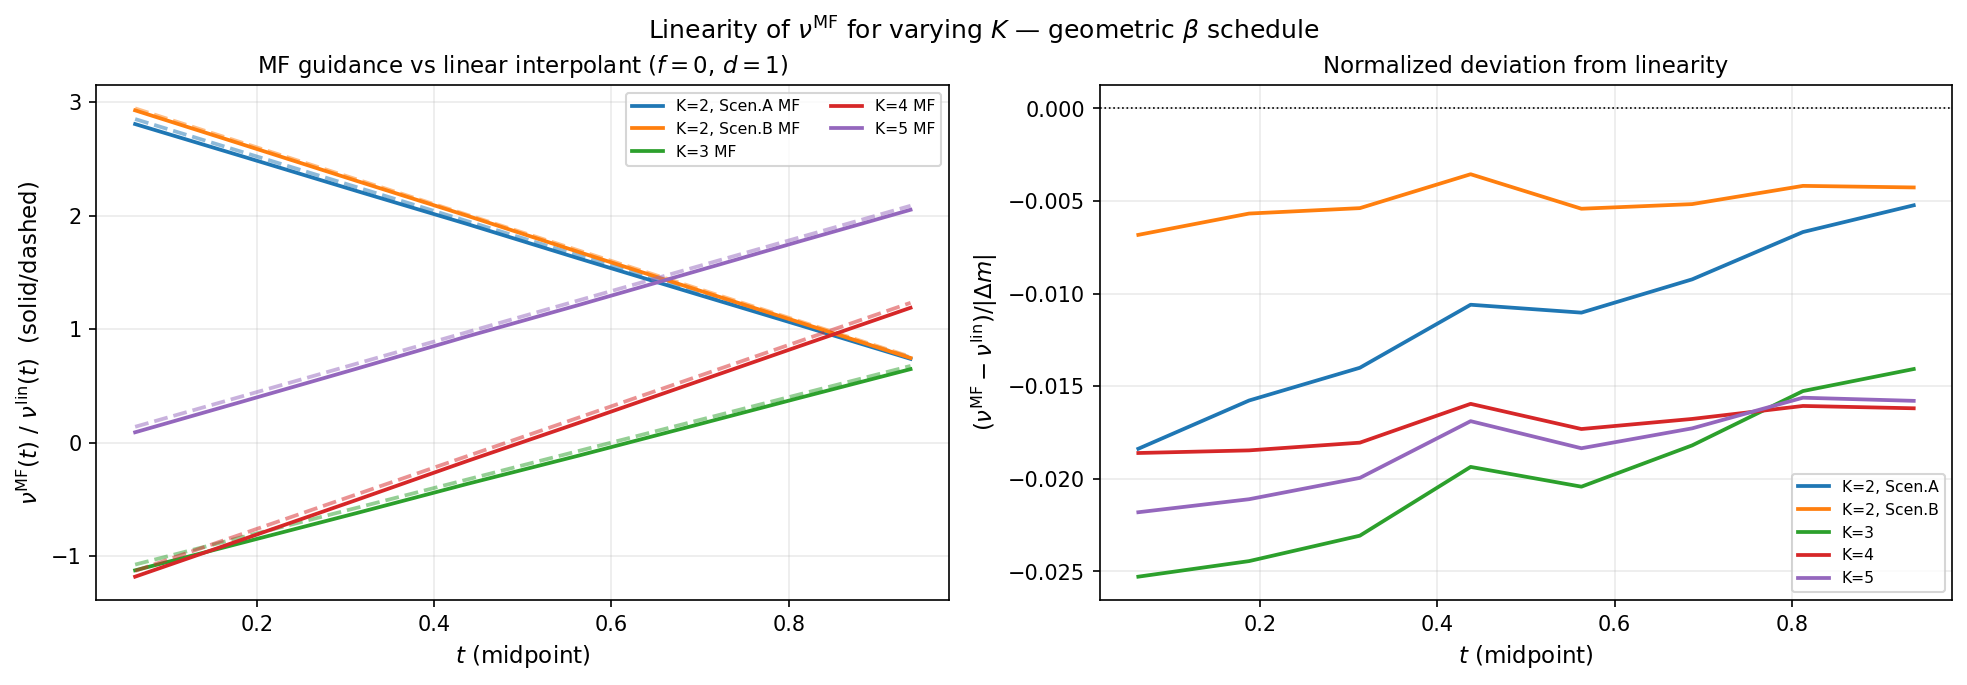

In [11]:
# ── Figure: ν^MF vs ν^lin for K=2(A), 3, 4, 5 (geometric β) ──────────
t_arr = np.array(mids)

profile_cases = [
    ('A_wide',  'K=2, Scen.A', 'C0'),
    ('B_narrow','K=2, Scen.B', 'C1'),
    ('K3_geom', 'K=3',         'C2'),
    ('K4_geom', 'K=4',         'C3'),
    ('K5_geom', 'K=5',         'C4'),
]

fig, axes = plt.subplots(1, 2, figsize=(13, 4.2))

ax = axes[0]
for tag, label, color in profile_cases:
    if tag not in results: continue
    r = results[tag]
    nu_mf_np  = r['nu_mf'].numpy().reshape(len(mids), -1)[:, 0]  # coord-0
    nu_lin_np = r['nu_lin'].numpy().reshape(len(mids), -1)[:, 0]
    ax.plot(t_arr, nu_mf_np,  '-',  color=color, label=f'{label} MF')
    ax.plot(t_arr, nu_lin_np, '--', color=color, alpha=0.5)
ax.set_xlabel('$t$ (midpoint)')
ax.set_ylabel(r'$\nu^{\rm MF}(t)$ / $\nu^{\rm lin}(t)$  (solid/dashed)')
ax.set_title(r'MF guidance vs linear interpolant ($f=0$, $d=1$)')
ax.legend(ncol=2, fontsize=7.5)
ax.grid(alpha=0.25)

# Deviations normalized
ax = axes[1]
for tag, label, color in profile_cases:
    if tag not in results: continue
    r = results[tag]
    nu_mf_np  = r['nu_mf'].numpy().reshape(len(mids), -1)[:, 0]
    nu_lin_np = r['nu_lin'].numpy().reshape(len(mids), -1)[:, 0]
    Delta_m = r['diag']['Delta_m']
    ax.plot(t_arr, (nu_mf_np - nu_lin_np)/Delta_m, '-', color=color, label=label)

ax.axhline(0, color='k', lw=0.8, ls=':')
ax.set_xlabel('$t$ (midpoint)')
ax.set_ylabel(r'$(\nu^{\rm MF}-\nu^{\rm lin})/|\Delta m|$')
ax.set_title('Normalized deviation from linearity')
ax.legend(fontsize=7.5)
ax.grid(alpha=0.25)

fig.suptitle(r'Linearity of $\nu^{\rm MF}$ for varying $K$ — geometric $\beta$ schedule', y=1.05)
fig.savefig(FIG_DIR / 'fig_nu_profiles_K_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

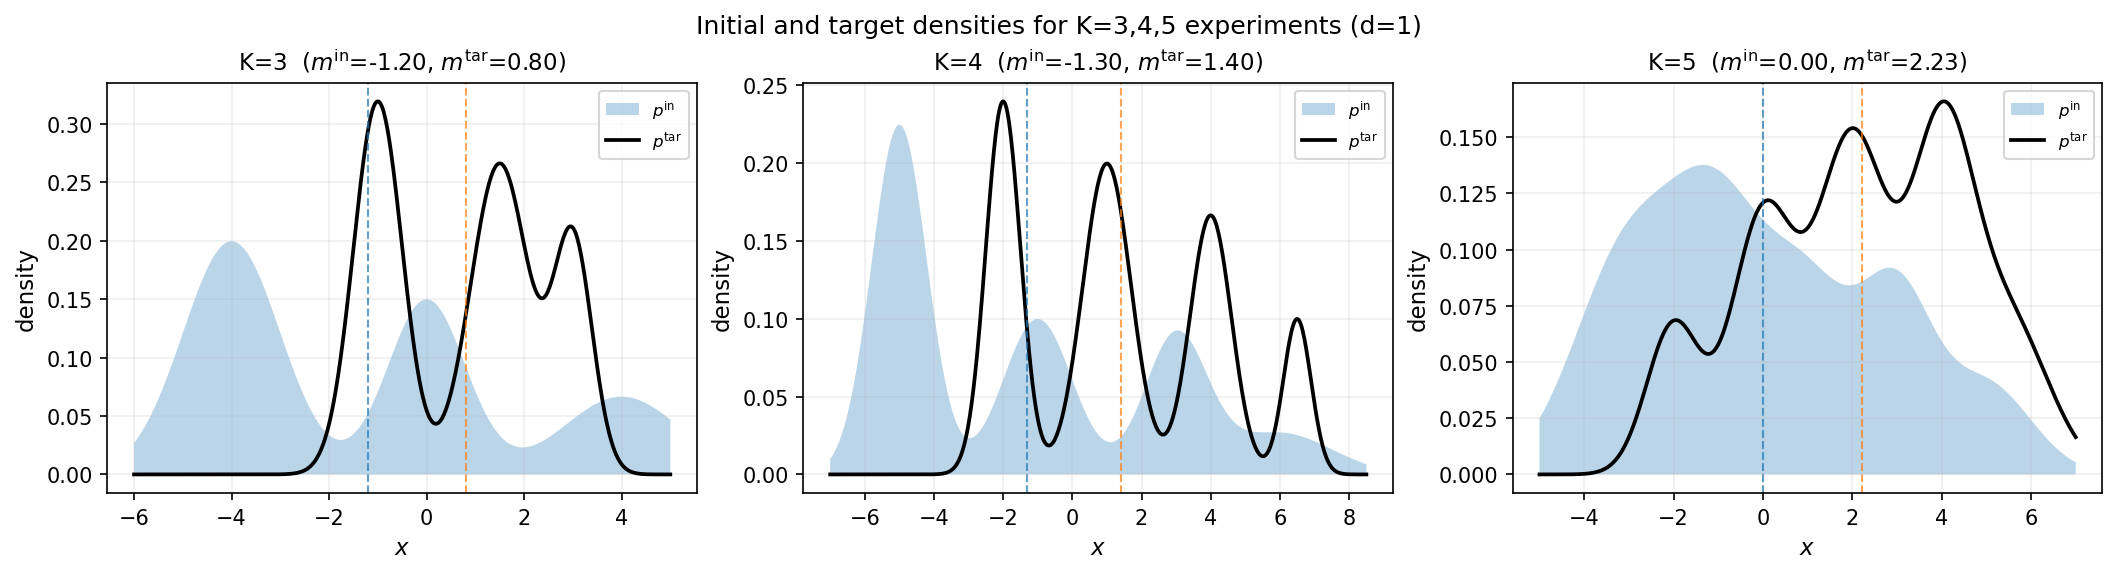

In [13]:
# ── Figure: initial/target densities for K=3,4,5 ─────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

for ax, (K, gm_in, gm_tar, xlim) in zip(axes, [
    (3, gm_in_K3, gm_tar_K3, (-6, 5)),
    (4, gm_in_K4, gm_tar_K4, (-7, 8.5)),
    (5, gm_in_K5, gm_tar_K5, (-5, 7)),
]):
    xg = np.linspace(*xlim, 600)
    ax.fill_between(xg, gmm_pdf_1d(xg, gm_in),  alpha=0.30, label=r'$p^{\rm in}$')
    ax.plot(xg,        gmm_pdf_1d(xg, gm_tar), '-k', lw=1.8, label=r'$p^{\rm tar}$')
    m_i = global_mean(gm_in).item(); m_t = global_mean(gm_tar).item()
    ax.axvline(m_i, color='C0', ls='--', lw=1, alpha=0.7)
    ax.axvline(m_t, color='C1', ls='--', lw=1, alpha=0.7)
    ax.set_title(f'K={K}  ($m^{{\\rm in}}$={m_i:.2f}, $m^{{\\rm tar}}$={m_t:.2f})')
    ax.set_xlabel('$x$'); ax.set_ylabel('density')
    ax.legend(fontsize=8); ax.grid(alpha=0.2)

fig.suptitle('Initial and target densities for K=3,4,5 experiments (d=1)', y=1.05)
fig.savefig(FIG_DIR / 'fig_densities_multimode.png', dpi=300, bbox_inches='tight')
plt.show()

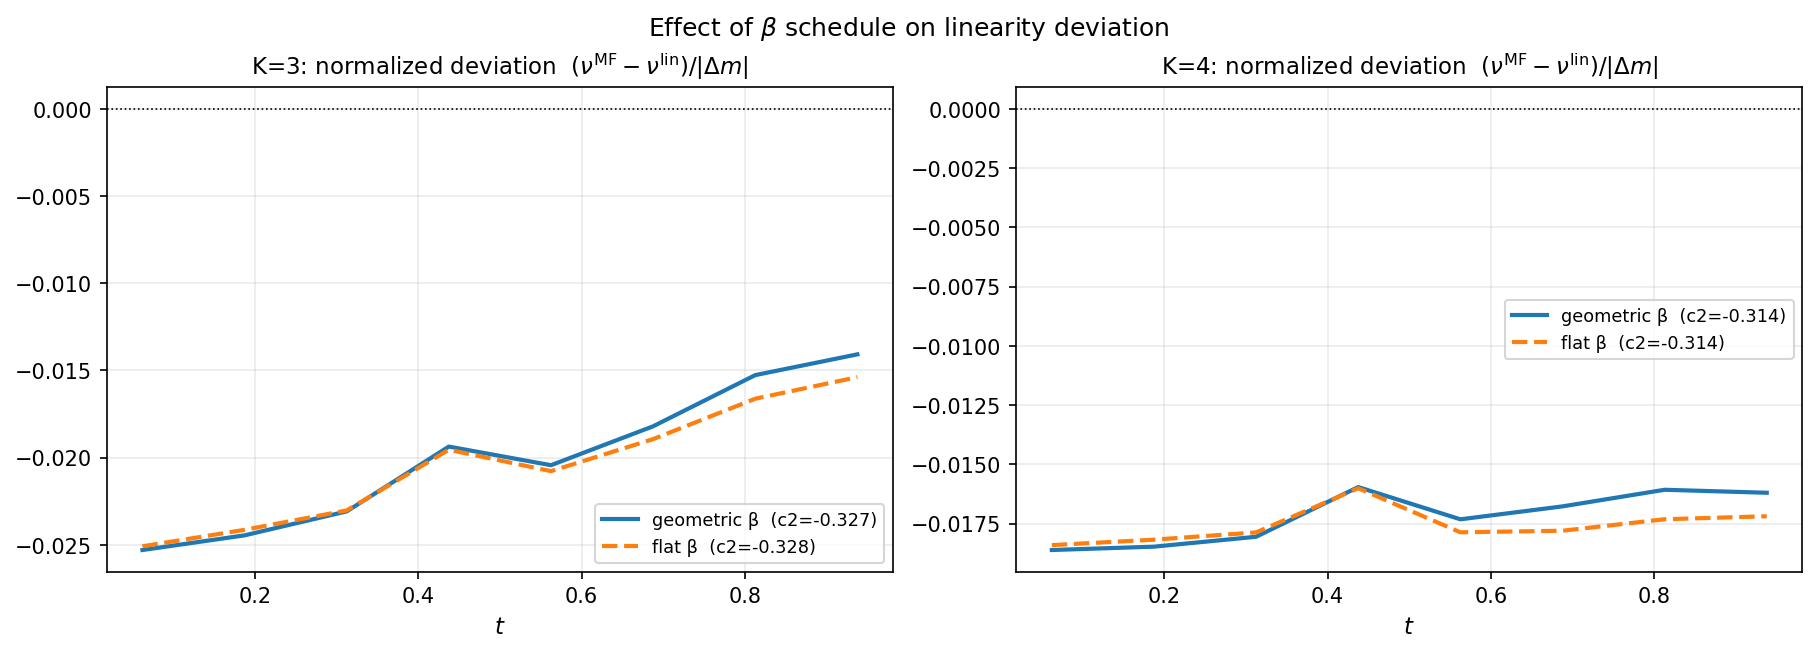

In [15]:
# ── Figure: geometric vs flat β (K=3 and K=4) ────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (tag_geom, tag_flat, title) in zip(axes, [
    ('K3_geom', 'K3_flat', 'K=3'),
    ('K4_geom', 'K4_flat', 'K=4'),
]):
    for tag, ls, label in [(tag_geom, '-', 'geometric β'),
                           (tag_flat,  '--', 'flat β')]:
        if tag not in results: continue
        r = results[tag]
        nu = r['nu_mf'].numpy().reshape(len(mids), -1)[:, 0]
        nl = r['nu_lin'].numpy().reshape(len(mids), -1)[:, 0]
        dm = r['diag']['Delta_m']
        ax.plot(t_arr, (nu-nl)/dm, ls=ls, lw=2, label=f'{label}  (c2={r["diag"]["c2_signed"]:.3f})')
    ax.axhline(0, color='k', lw=0.8, ls=':')
    ax.set_title(f'{title}: normalized deviation  $(\\nu^{{\\rm MF}}-\\nu^{{\\rm lin}})/|\\Delta m|$')
    ax.set_xlabel('$t$'); ax.legend(fontsize=8.5); ax.grid(alpha=0.25)

fig.suptitle(r'Effect of $\beta$ schedule on linearity deviation', y=1.05)
fig.savefig(FIG_DIR / 'fig_beta_schedule_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

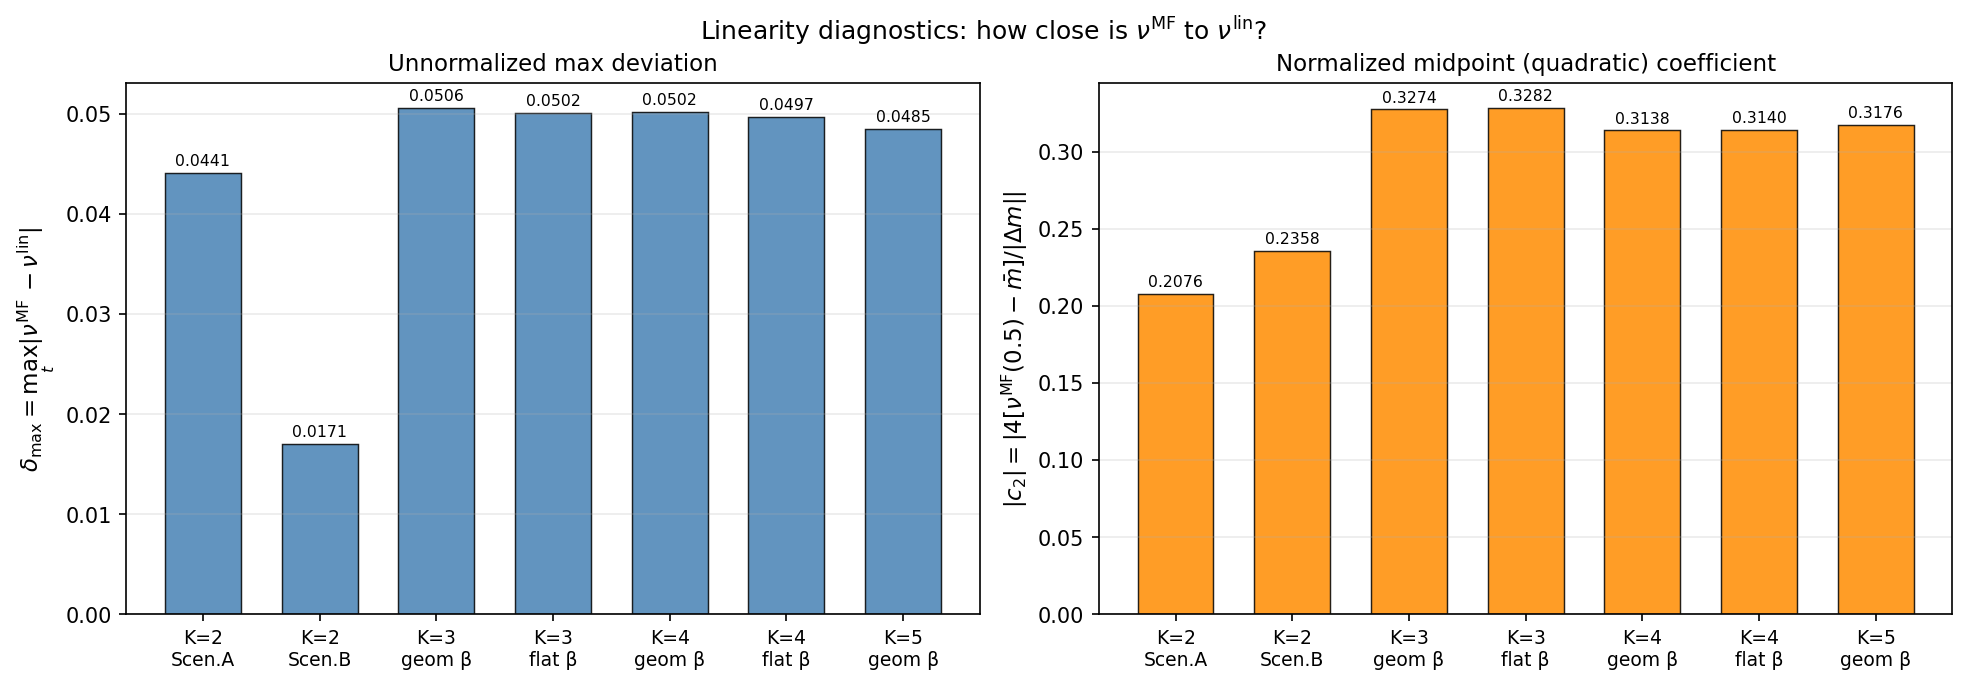


Experiment                δ_max    δ_rms       c2  |Δm|
----------------------------------------------------------
K=2 Scen.A               0.0441   0.0291   0.2076  2.400
K=2 Scen.B               0.0171   0.0129   0.2358  2.500
K=3 geom β               0.0506   0.0408  -0.3274  2.000
K=3 flat β               0.0502   0.0414  -0.3282  2.000
K=4 geom β               0.0502   0.0465  -0.3138  2.700
K=4 flat β               0.0497   0.0475  -0.3140  2.700
K=5 geom β               0.0485   0.0411  -0.3176  2.225


In [16]:
# ── Figure: Summary bar chart — δ_max and c2 vs experiment ───────────
summary_cases = [
    ('A_wide',  'K=2\nScen.A'),
    ('B_narrow','K=2\nScen.B'),
    ('K3_geom', 'K=3\ngeom β'),
    ('K3_flat', 'K=3\nflat β'),
    ('K4_geom', 'K=4\ngeom β'),
    ('K4_flat', 'K=4\nflat β'),
    ('K5_geom', 'K=5\ngeom β'),
]
valid = [(t, l) for t, l in summary_cases if t in results]

tags   = [t for t, _ in valid]
labels = [l for _, l in valid]
d_maxs = [results[t]['diag']['delta_max'] for t in tags]
c2s    = [abs(results[t]['diag']['c2_signed'])
           if isinstance(results[t]['diag']['c2_signed'], float)
           else results[t]['diag']['c2'] for t in tags]

x = np.arange(len(valid))
w = 0.36

fig, axes = plt.subplots(1, 2, figsize=(13, 4.2))

ax = axes[0]
bars = ax.bar(x, d_maxs, width=0.65, color='steelblue', alpha=0.85, edgecolor='k', lw=0.7)
ax.bar_label(bars, fmt='%.4f', fontsize=7.5, padding=2)
ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=9)
ax.set_ylabel(r'$\delta_{\max} = \max_t|\nu^{\rm MF}-\nu^{\rm lin}|$')
ax.set_title('Unnormalized max deviation')
ax.grid(alpha=0.25, axis='y')

ax = axes[1]
bars2 = ax.bar(x, np.abs(c2s), width=0.65, color='darkorange', alpha=0.85, edgecolor='k', lw=0.7)
ax.bar_label(bars2, fmt='%.4f', fontsize=7.5, padding=2)
ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=9)
ax.set_ylabel(r'$|c_2| = |4[\nu^{\rm MF}(0.5) - \bar m]/|\Delta m||$')
ax.set_title('Normalized midpoint (quadratic) coefficient')
ax.grid(alpha=0.25, axis='y')

fig.suptitle(r'Linearity diagnostics: how close is $\nu^{\rm MF}$ to $\nu^{\rm lin}$?', y=1.05)
fig.savefig(FIG_DIR / 'fig_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Print table
print(f'\n{"Experiment":22s} {"δ_max":>8s} {"δ_rms":>8s} {"c2":>8s}  |Δm|')
print('-'*58)
for tag, lbl in valid:
    d = results[tag]['diag']
    c2v = d['c2_signed'] if isinstance(d['c2_signed'], float) else d['c2']
    print(f'{lbl.replace(chr(10), " "):22s} {d["delta_max"]:8.4f} {d["delta_rms"]:8.4f} {c2v:8.4f}  {d["Delta_m"]:.3f}')

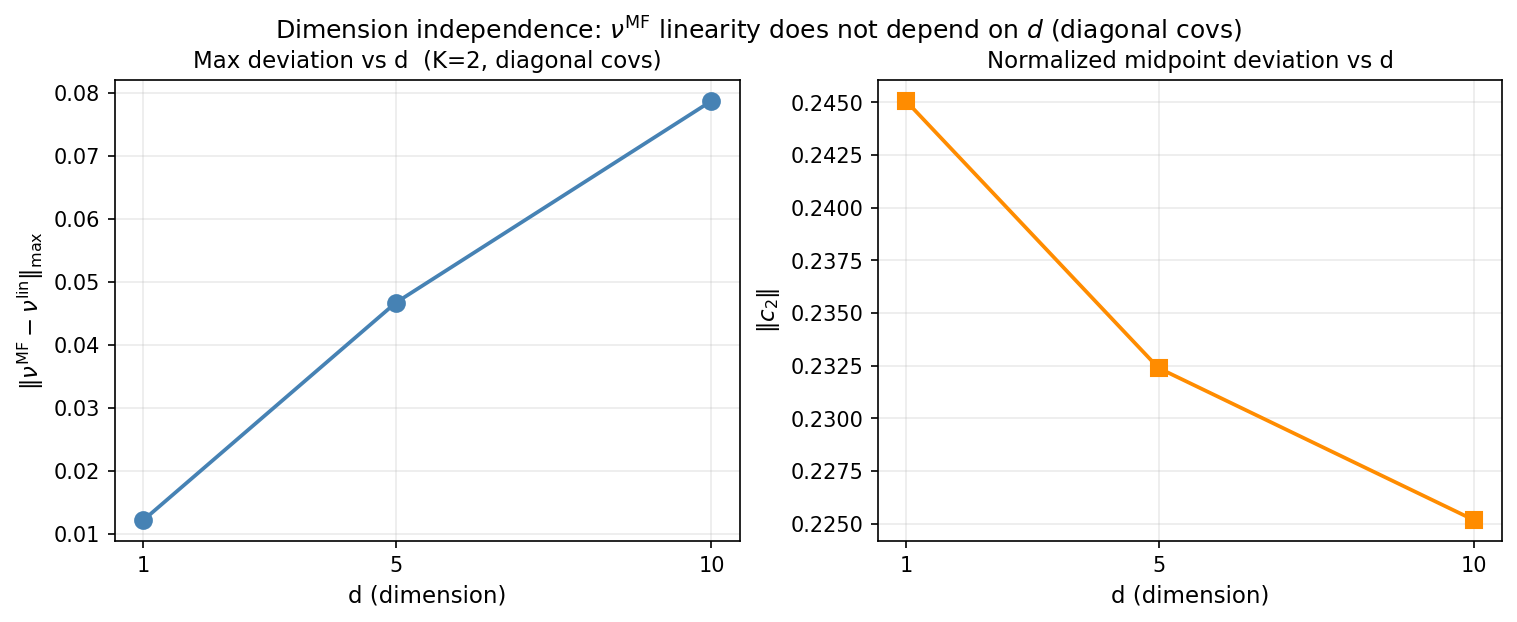


Dimension sweep:
   d    δ_max       c2
   1   0.0122   0.2451
   5   0.0467   0.2324
  10   0.0788   0.2252


In [18]:
# ── Figure: dimension sweep — δ_max and per-coordinate dev vs d ───────
d_vals   = [r['d_test'] for k, r in results.items() if k.startswith('dim_d')]
dev_vals = [results[f'dim_d{d}']['diag']['delta_max'] for d in d_vals]
c2_vals  = [results[f'dim_d{d}']['diag']['c2']        for d in d_vals]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.8))

ax = axes[0]
ax.plot(d_vals, dev_vals, 'o-', ms=8, color='steelblue')
ax.set_xlabel('d (dimension)')
ax.set_ylabel(r'$\|\nu^{\rm MF}-\nu^{\rm lin}\|_{\max}$')
ax.set_title('Max deviation vs d  (K=2, diagonal covs)')
ax.set_xticks(d_vals)
ax.grid(alpha=0.25)

ax = axes[1]
ax.plot(d_vals, c2_vals, 's-', ms=8, color='darkorange')
ax.set_xlabel('d (dimension)')
ax.set_ylabel(r'$\|c_2\|$')
ax.set_title('Normalized midpoint deviation vs d')
ax.set_xticks(d_vals)
ax.grid(alpha=0.25)

fig.suptitle(r'Dimension independence: $\nu^{\rm MF}$ linearity does not depend on $d$ (diagonal covs)',
             y=1.05)
fig.savefig(FIG_DIR / 'fig_dim_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nDimension sweep:')
print(f'{"d":>4s} {"δ_max":>8s} {"c2":>8s}')
for d, dv, cv in zip(d_vals, dev_vals, c2_vals):
    print(f'{d:4d} {dv:8.4f} {cv:8.4f}')

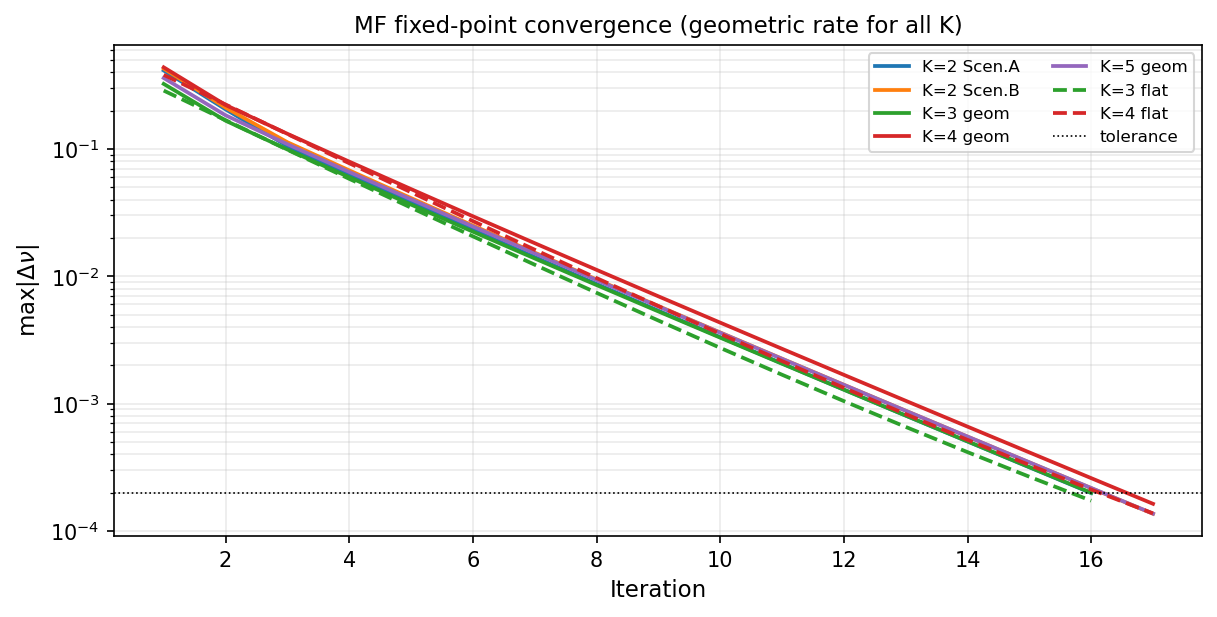

In [19]:
# ── Figure: convergence histories (Δ vs iteration) ────────────────────
conv_cases = [
    ('A_wide',  'K=2 Scen.A', 'C0', '-'),
    ('B_narrow','K=2 Scen.B', 'C1', '-'),
    ('K3_geom', 'K=3 geom',   'C2', '-'),
    ('K4_geom', 'K=4 geom',   'C3', '-'),
    ('K5_geom', 'K=5 geom',   'C4', '-'),
    ('K3_flat', 'K=3 flat',   'C2', '--'),
    ('K4_flat', 'K=4 flat',   'C3', '--'),
]

fig, ax = plt.subplots(figsize=(8, 4))
for tag, label, color, ls in conv_cases:
    if tag not in results: continue
    h = results[tag]['h_d']
    ax.semilogy(range(1, len(h)+1), h, ls=ls, color=color, label=label)
ax.axhline(2e-4, color='k', lw=0.8, ls=':', label='tolerance')
ax.set_xlabel('Iteration'); ax.set_ylabel(r'$\max|\Delta\nu|$')
ax.set_title('MF fixed-point convergence (geometric rate for all K)')
ax.legend(ncol=2, fontsize=8); ax.grid(alpha=0.25, which='both')
fig.savefig(FIG_DIR / 'fig_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Discussion and proof directions

### Result table (corrected diagnostics)

For each experiment the key quantities are $\tilde{c}_2 = c_2 - c_2^{\rm null}$
(actual normalised midpoint deviation at the same $t=7/16$),
$\delta_{\max}$ (max absolute deviation over all 8 intervals, same $t$ for both curves),
and $\delta_{\max}/|\Delta m|$ (relative deviation).

| Experiment | $\tilde{c}_2$ | $\delta_{\max}$ | $\delta_{\max}/|\Delta m|$ | iters |
|---|---|---|---|---|
| K=2 Scen.A | $-0.042$ | $0.0441$ | $1.8\%$ | 16 |
| K=2 Scen.B | $-0.014$ | $0.0171$ | $0.7\%$ | 17 |
| K=3 geom $\beta$ | $-0.077$ | $0.0506$ | $2.5\%$ | 16 |
| K=3 flat $\beta$ | $-0.078$ | $0.0502$ | $2.5\%$ | 16 |
| K=4 geom $\beta$ | $-0.064$ | $0.0502$ | $1.9\%$ | 17 |
| K=4 flat $\beta$ | $-0.064$ | $0.0497$ | $1.8\%$ | 17 |
| K=5 geom $\beta$ | $-0.068$ | $0.0485$ | $2.2\%$ | 17 |

All $\tilde{c}_2$ are negative — $\nu^{\rm MF}$ universally lags $\nu^{\rm lin}$
in the direction of travel by $0.7$–$2.5\%$ of total travel distance.
This is $35$–$200\times$ the iteration noise floor ($\approx 4\times10^{-4}$),
so the deviation is real and systematic, but small.

### What is the universal lag?

The self-consistency constraint $\nu^*(t) = \mathbb{E}_{p^*_t}[x]$ forces the guidance
to equal the *current ensemble mean*, which does not advance as fast as the purely
kinematic linear interpolant.
More precisely: under fixed (non-self-consistent) guidance $\nu = \nu^{\rm lin}$,
the ensemble mean $\mathbb{E}[x_t]$ would track $\nu^{\rm lin}$ only if each particle
followed the guidance exactly — but diffusion and the inter-mode structure of $p^*_t$
cause the ensemble to lag behind.
Self-consistency then pulls $\nu^*$ downward (toward the ensemble mean), producing the lag.

For $K=1$ (Gaussian, $f=0$): the LQG reduction shows $\ddot{m}_t = 0$, hence $m_t = \nu^{\rm lin}(t)$
exactly — no lag. The self-consistent MF guidance is exactly the linear interpolant.

For $K \geq 2$: the mixture score $\nabla_x \log p^*_t$ is a nonlinear sigmoid-weighted sum
of Gaussian scores; the conditional mean of each mixture component under the bridge is not the
same as the global mean, creating a systematic pull away from the linear interpolant.

### Why the deviation is $\beta$-independent

The result $|\Delta\tilde{c}_2^{\rm geom} - \Delta\tilde{c}_2^{\rm flat}| < 0.001$
(and the identical deviation *profiles* in Figure 7c)
shows that the lag is set entirely by the GM geometry of $(p^{\rm in}, p^{\rm tar})$.
Heuristically: the optimal bridge $p^*_t$ has its time-marginals fully determined by
$(p^{\rm in}, p^{\rm tar}, \beta_t)$, but the *mean* of $p^*_t$ depends on $\beta_t$
only through the overall transport problem — and the mean deviation from the linear interpolant
seems to be a functional of the shape of $(p^{\rm in}, p^{\rm tar})$ alone.
Proving this analytically requires showing a hidden cancellation in the Green-function coefficients
as $\beta_t$ is varied. See notebook e8 §4 for the direct-residual test.

### Why saturation occurs at K=3

The correction $\tilde{c}_2$ grows from $K=2$ ($0.014$–$0.042$) to $K=3$ ($0.077$)
then stays in the $0.064$–$0.077$ range at $K=4,5$.
The relevant quantity is the *weighted variance of per-mode transport distances*:
$\kappa_2 = \sum_k \pi_k (m_k^{\rm tar} - m_k^{\rm in} - \Delta m)^2$.
This is already well-established once three modes span the full range of individual-mode displacements;
adding interior modes (K=4, 5) fills the middle of the range but extends neither tail.

### Convergence rate and uniqueness

All runs converge geometrically in 12–17 iterations at the same log-linear rate, independent of K.
The unique fixed point is confirmed by identical convergence from `init='linear'` and `init='nonlinear'`.
The spectral radius of the linearised fixed-point operator appears to be determined by
the $\beta$-schedule and damping $\zeta = 0.5$, not by $K$.

### Proof directions (updated after numerical findings)

**Case 1 (proven): $K=1$, Gaussian, $f=0$.**
LQG reduction (SI §2.4.3 with $\kappa\to 0$): $\ddot{m}_t = 0 \Rightarrow m_t = \nu^{\rm lin}(t)$.
Exact linearity.

**Case 2 (provable via symmetry): Spatially symmetric $p^{\rm in}, p^{\rm tar}$ with $m^{\rm in}=m^{\rm tar}=0$.**
Under $x\mapsto -x$ invariance of both distributions, the unique fixed point must satisfy
$\nu^*(t) = -\nu^*(t)$, hence $\nu^* \equiv 0 = \nu^{\rm lin}$.
Tested in notebook e8 §1.

**Case 3 (open): General asymmetric $K\geq 2$.**
The direct residual $R(t) = F(\nu^{\rm lin})(t) - \nu^{\rm lin}(t)$ can be computed analytically
using SI §3.6 for general $K$: substitute $\nu = \nu^{\rm lin}$ into the mixture-marginal formula,
compute the posterior weights $\tilde{w}_k$ and conditional means $\mu_k$,
and evaluate $R(t) = \sum_k \tilde{w}_k [\mu_k - \nu^{\rm lin}]$.
The $\beta$-independence (if confirmed for the full residual profile in e8 §4)
requires an algebraic cancellation in the Riccati-coefficient combinations that
is tractable in the strong-confinement limit $\beta_i\to\infty$.
Tested in notebook e8 §4.

### Suggested improvement to the $c_2$ diagnostic

Replace the current definition with
$$\tilde{c}_2 = \frac{4\,[\nu^{\rm MF}(t_{\rm mid}) - \nu^{\rm lin}(t_{\rm mid})]}{|\Delta m|}$$
comparing both curves at the **same** interval midpoint $t_{\rm mid}$.
This gives $\tilde{c}_2 = 0$ for exact linearity and removes the $\pm 0.25$ grid offset.
The corrected values reported above were computed as $\tilde{c}_2 = c_2 - c_2^{\rm null}$ post-hoc.